Let's think about a sound we want to create. Have you ever heard an orchestra or symphony tuning together at the start of a performance?


In [1]:
from IPython.display import HTML, Audio, display, clear_output
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/KfSH1ezevjM?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

The tone they're tuning to is "A 440". It's the note A, at 440 _Hertz_.

In [27]:
tone_frequency = 440
tone_amplitude = 1.0

Let's set up some other parameters for our audio wave. Let's say it should run for 4 seconds duration.

TODO: image showing digital audio

For digital audio, we need a sampling rate. Let's set the sampling rate to 48,000 samples per second (also known as _Hertz_ or Hz), fast enough to capture all sounds in the range of human hearing. We could generate other very low or high pitches with this sampling rate.

The space between samples is only 1/48000 of a second! T is this _period_ of a single sample, or the time between successive samples.

In [23]:
duration_sec = 4
rate_Hz = 44100
T = 1/rate_Hz
print ("One digital audio sample lasts just {:.10f} seconds!".format(T))

One digital audio sample lasts just 0.0000226757 seconds!


We need a timeline of samples, t. It should be a list of numbers representing the clock time for each sample. It starts at time zero, the next number is T, then 2*T, 3*T, and so on.

To help us make this list, we import numpy, which is a Python library useful for manipulating numbers, vectors, and matrices in Python.

numpy makes this for us automatically, if we give it the start value, the end value, and the number of steps to take inbetween.

In [24]:
import numpy as np
t = np.linspace(0, duration_sec, duration_sec*rate_Hz+1)
print ("Our list of sample times: {}".format(t))

Our list of sample times: [0.00000000e+00 2.26757370e-05 4.53514739e-05 ... 3.99995465e+00
 3.99997732e+00 4.00000000e+00]


Finally let's make values for the digital wave, using the sine function, on our times t. numpy helps us again by providing the sine function and the constant Pi.

In [42]:
wave = tone_amplitude * np.sin( tone_frequency * 2 * np.pi * t)
display(Audio(wave, rate=rate_Hz))

In [41]:
max(wave)

0.999999746257888

In [88]:
sd.default.samplerate=48000
sd.default.device = 'Built'
max_duration = 5 # seconds
myrecording = sd.rec(max_duration*rate_Hz, samplerate=rate_Hz, device=0, channels=1)
sd.wait()

In [100]:
def view_audio(audio, Fs, min_sample=0, max_sample=-1):
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    ax1.plot(audio[min_sample:max_sample].squeeze()); ax1.set_title('Audio Samples')
    ax2.specgram(audio[min_sample:max_sample].squeeze(), Fs=Fs); ax2.set_title('Spectrogram'); ax2.set_yscale('log');ax2.set_ylim(1,20000)
    import matplotlib.mlab as mlab
    Pxx, freq, t = mlab.specgram(audio[min_sample:max_sample].squeeze(), Fs=Fs)
    ax3.pcolor(t, freq, Pxx); ax3; ax3.set_yscale('log'); ax3.set_ylim(20,20000)
    display(Audio(audio.squeeze(), rate=rate_Hz))

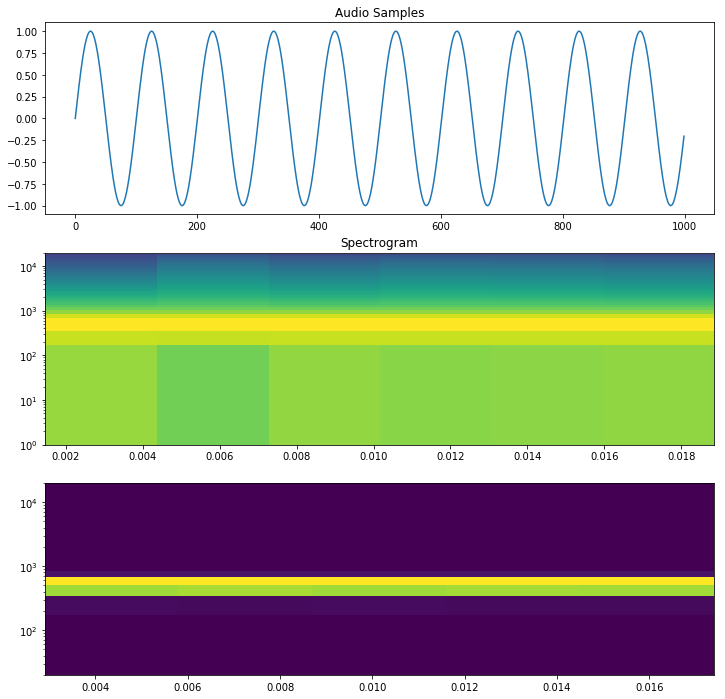

In [101]:
view_audio(wave, rate_Hz, min_sample=0, max_sample=1000)

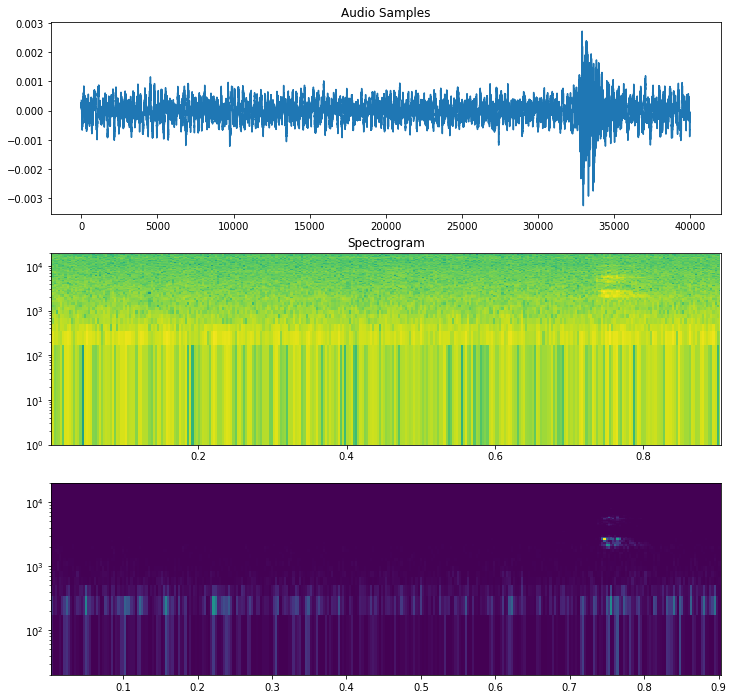

In [102]:
view_audio(myrecording, rate_Hz, min_sample=60000, max_sample=100000)

In [75]:
import sounddevice as sd
print(sd.query_devices())

> 0 Built-in Microphone, Core Audio (2 in, 0 out)
< 1 Built-in Output, Core Audio (0 in, 2 out)
  2 HDMI, Core Audio (0 in, 2 out)
  3 eqMac, Core Audio (2 in, 2 out)
  4 JBL Reflect Mini BT, Core Audio (1 in, 0 out)
  5 JBL Reflect Mini BT, Core Audio (0 in, 2 out)
